In [65]:
!pip install pandas
import pandas as pd
import numpy as np

In [66]:
df= pd.read_excel("Online Retail.xlsx")

In [67]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


the variables Description and CustomerID have missing data

In [63]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

#Fills missing values of discription as Unknown
df['Description']=df['Description'].fillna('Unknown')

# Remove canceled orders (Quantity < 0)
df = df[df['Quantity'] > 0]

# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


Now,all the missing values are handled.

# Future engineering

Recency:	How many days ago the customer made their last purchase

Frequency:	How many different purchases (invoices) they made

AOV (Average Order Value):	Average amount spent per purchase

In [56]:
import datetime

# Reference date (1 day after the last InvoiceDate)
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

# Group by CustomerID
customers = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# Rename columns
customers.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'TotalRevenue'
}, inplace=True)


# Calculate AOV: Total Revenue divided by Frequency
customers['AOV'] = customers['TotalRevenue'] / customers['Frequency']

# Create Monetary feature
customers['Monetary'] = customers['Frequency'] * customers['AOV']

# Create Average Order Gap feature
customers['Avg_Order_Gap'] = customers['Recency'] / customers['Frequency']

# Replace infinite values (in case Frequency = 0)
customers['Avg_Order_Gap']=customers['Avg_Order_Gap'].replace([np.inf, -np.inf], np.nan)
customers['Avg_Order_Gap']=customers['Avg_Order_Gap'].fillna(customers['Avg_Order_Gap'].median())

# Final dataset
customers = customers[['Recency', 'Frequency', 'AOV', 'Monetary', 'Avg_Order_Gap']]
customers.head()


,Recency,Frequency,AOV,Monetary,Avg_Order_Gap
CustomerID,,,,,
12346.0,326,1,77183.600000,77183.60,326.000000
12347.0,2,7,615.714286,4310.00,0.285714
12348.0,75,4,449.310000,1797.24,18.750000
12349.0,19,1,1757.550000,1757.55,19.000000
12350.0,310,1,334.400000,334.40,310.000000


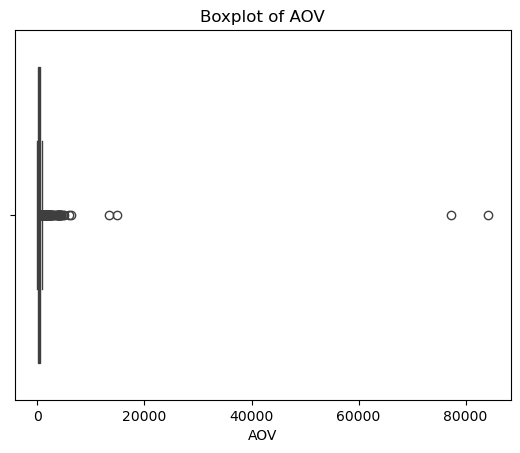

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Single feature
sns.boxplot(x=customers['AOV'])
plt.title('Boxplot of AOV')
plt.show()

In [86]:
#removing the outliers

# Remove top 1% AOV customers
q = customers['AOV'].quantile(0.99)
customers_filtered = customers[customers['AOV'] < q]

# Train a Model to Predict Lifetime Value

In [87]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

features = ['Recency', 'Frequency', 'Monetary', 'Avg_Order_Gap']
X = customers_filtered[features]
y = customers_filtered['AOV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train the XGBoost Model

# Define and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

#Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

# Print Results
print(f'MAE after using XGBoost: {mae:.2f}')
print(f'RMSE after using XGBoost: {rmse:.2f}')
print(f"Train R²: {r2_train:.2f}")
print(f"Test R²: {r2_test:.2f}")

MAE after using XGBoost: 7.17
RMSE after using XGBoost: 24.88
Train R²: 1.00
Test R²: 0.99


Train R² = 1.00: the model explains 100% of the variance on training data (perfect fit).

Test R² = 0.99: the model explains 99% of the variance on unseen/test data.

The model generalizes very well — no overfitting.

It is a very strong, reliable model for predicting AOV (Average Order Value).

# Customer Segmentation Based on Predicted LTV

In [88]:
#Predict AOV for All Customers ---
customers_filtered.loc[:, 'Predicted_AOV'] = model.predict(customers_filtered[features])

# Estimate LTV (simple model: Predicted_AOV × Frequency)
customers_filtered.loc[:, 'Predicted_LTV'] = customers_filtered['Predicted_AOV'] * customers_filtered['Frequency']

# Define segmentation thresholds (adjust based on your data analysis)
low_threshold = 50  # Adjust this threshold based on LTV distribution
high_threshold = 150

def segment_customer(row):
    if row['Predicted_LTV'] < low_threshold:
        return 'Low Value'
    elif row['Predicted_LTV'] >= low_threshold and row['Predicted_LTV'] < high_threshold:
        return 'Medium Value'
    else:
        return 'High Value'

customers_filtered.loc[:,'LTV_Segment'] = customers_filtered.apply(segment_customer, axis=1)

C:\Users\Varsha\AppData\Local\Temp\ipykernel_22940\2981438853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_filtered.loc[:, 'Predicted_AOV'] = model.predict(customers_filtered[features])
C:\Users\Varsha\AppData\Local\Temp\ipykernel_22940\2981438853.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_filtered.loc[:, 'Predicted_LTV'] = customers_filtered['Predicted_AOV'] * customers_filtered['Frequency']
C:\Users\Varsha\AppData\Local\Temp\ipykernel_22940\2981438853.py:19: SettingWith

In [91]:
#Save the results to CSV
customers_filtered.to_csv('segmented_customers_predicted_LTV.csv', index=False)

print("Customer segmentation and LTV prediction completed. Results saved to 'segmented_customers_LTV.csv'.")

Customer segmentation and LTV prediction completed. Results saved to 'segmented_customers_LTV.csv'.


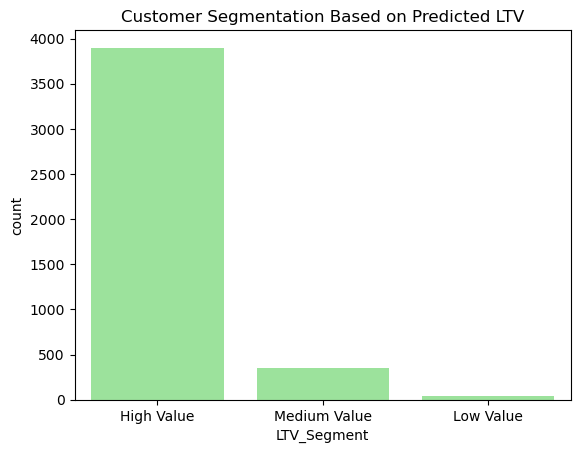

In [92]:
#Visualize Segmentation
sns.countplot(x='LTV_Segment', data=customers_filtered, color='lightgreen')
plt.title('Customer Segmentation Based on Predicted LTV')
plt.show()